# Import Libraries

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option("display.max.columns", None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import plotly.graph_objects as go

from tapy import Indicators

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, 
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix
)

import xgboost
from xgboost import XGBClassifier

from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import to_categorical

# D1 Timeframe

In [2]:
# read in 2019 full year 1 hour timeframe price data
df_d1_feature = pd.read_csv('../data/df_d1_feature.csv', index_col=0)
df_d1_feature.index = pd.to_datetime(df_d1_feature.index)
df_d1_feature = df_d1_feature.dropna()
df_d1_feature.head()

,open,high,low,close,results,day_of_wk,shift_01,close_shift_01_dist,shift_02,close_shift_02_dist,shift_03,close_shift_03_dist,shift_05,close_shift_05_dist,shift_08,close_shift_08_dist,shift_13,close_shift_13_dist,shift_21,close_shift_21_dist,shift_34,close_shift_34_dist,shift_55,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,sma_03,close_sma_03_dist,sma_05,close_sma_05_dist,sma_08,close_sma_08_dist,sma_13,close_sma_13_dist,sma_21,close_sma_21_dist,sma_34,close_sma_34_dist,sma_55,close_sma_55_dist,sma_89,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,diff,gain,loss,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_05m02,rsi_14_shift_05m01,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-04-15,1.0772,1.0822,1.0738,1.0802,1,1,1.0773,2.9,1.0754,4.8,1.0755,4.7,1.0781,2.1,1.0644,15.8,1.0914,-11.2,1.0525,27.7,1.0993,-19.1,1.0729,7.3,1.0476,32.6,-1.9,0.1,-1.8,2.6,2.7,0.8,-13.7,-11.1,-11.0,-12.9,27.0,13.3,15.9,16.0,14.1,-38.9,-11.9,-25.6,-23.0,-22.9,-24.8,46.8,7.9,34.9,21.2,23.8,23.9,22.0,-26.4,20.4,-18.5,8.5,-5.2,-2.6,-2.5,-4.4,-25.3,-51.7,-4.9,-43.8,-16.8,-30.5,-27.9,-27.8,-29.7,1.07875,1.45,1.077633,2.566667,1.07732,2.88,1.075587,4.6125,1.075538,4.661538,1.074671,5.528571,1.076515,3.685294,1.078116,2.083636,1.074019,6.180899,-1.116667e+00,-0.313333,-1.43,-1.7325,-2.045833,-3.1625,-0.049038,-1.781538,-2.094872,-3.211538,-0.867033,-0.916071,-2.648571,-2.961905,-4.078571,1.843277,0.976244,0.927206,-0.805294,-1.118627,-2.235294,1.601658,3.444935,2.577902,2.528864,0.796364,0.483030,-0.633636,-4.097263,-2.495605,-0.652327,-1.519360,-1.568399,-3.300899,-3.614232,-4.730899,0.0029,0.0029,0.0000,59.593582,54.539032,-5.054550,51.063056,-8.530526,51.241771,-8.351811,55.685796,-3.907787,36.309679,-23.283904,70.687929,11.094347,22.555143,-37.038439,-3.475976,0.178715,-3.297261,4.444024,4.622739,1.146764,-19.376117,-14.932093,-14.753378,-18.229353,34.378251,15.002134,19.446158,19.624873,16.148897,-48.132786,-13.754535,-33.130652,-28.686628,-28.507913,-31.983889,57.066307,55.065223,54.450024,52.171192,50.922280,51.468761,-2.001084,-0.615199,-2.616283,-2.278833,-2.894032,-4.895115,-1.248911,-3.527744,-4.142943,-6.144027,0.546481,-0.702431,-2.981263,-3.596462,-5.597546
2003-04-16,1.0803,1.0979,1.0800,1

In [3]:
df_d1_feature.shape

(5211, 185)

In [4]:
df_d1_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5211 entries, 2003-04-15 to 2019-12-23
Columns: 185 entries, open to rsi_14_sma_21m02
dtypes: float64(183), int64(2)
memory usage: 7.4 MB


In [5]:
non_feature = ['open', 'high', 'low', 'close', 'results',
               'shift_01', 'shift_02', 'shift_03', 'shift_05', 
               'shift_08', 'shift_13', 'shift_21', 'shift_34',
               'shift_55', 'shift_89'
               'sma_02', 'sma_03', 'sma_05', 'sma_08', 
               'sma_13', 'sma_21', 'sma_34', 'sma_55', 'sma_89',
               'diff','gain','loss']
features = [col for col in df_d1_feature.columns if col not in non_feature]

X = df_d1_feature[features]
y = df_d1_feature['results']

## Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False )

In [7]:
X_train.head()

,day_of_wk,close_shift_01_dist,close_shift_02_dist,close_shift_03_dist,close_shift_05_dist,close_shift_08_dist,close_shift_13_dist,close_shift_21_dist,close_shift_34_dist,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,close_sma_03_dist,close_sma_05_dist,close_sma_08_dist,close_sma_13_dist,close_sma_21_dist,close_sma_34_dist,close_sma_55_dist,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_05m02,rsi_14_shift_05m01,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-04-15,1,2.9,4.8,4.7,2.1,15.8,-11.2,27.7,-19.1,7.3,1.0476,32.6,-1.9,0.1,-1.8,2.6,2.7,0.8,-13.7,-11.1,-11.0,-12.9,27.0,13.3,15.9,16.0,14.1,-38.9,-11.9,-25.6,-23.0,-22.9,-24.8,46.8,7.9,34.9,21.2,23.8,23.9,22.0,-26.4,20.4,-18.5,8.5,-5.2,-2.6,-2.5,-4.4,-25.3,-51.7,-4.9,-43.8,-16.8,-30.5,-27.9,-27.8,-29.7,1.07875,1.45,2.566667,2.88,4.6125,4.661538,5.528571,3.685294,2.083636,6.180899,-1.116667e+00,-0.313333,-1.43,-1.7325,-2.045833,-3.1625,-0.049038,-1.781538,-2.094872,-3.211538,-0.867033,-0.916071,-2.648571,-2.961905,-4.078571,1.843277,0.976244,0.927206,-0.805294,-1.118627,-2.235294,1.601658,3.444935,2.577902,2.528864,0.796364,0.483030,-0.633636,-4.097263,-2.495605,-0.652327,-1.519360,-1.568399,-3.300899,-3.614232,-4.730899,59.593582,54.539032,-5.054550,51.063056,-8.530526,51.241771,-8.351811,55.685796,-3.907787,36.309679,-23.283904,70.687929,11.094347,22.555143,-37.038439,-3.475976,0.178715,-3.297261,4.444024,4.622739,1.146764,-19.376117,-14.932093,-14.753378,-18.229353,34.378251,15.002134,19.446158,19.624873,16.148897,-48.132786,-13.754535,-33.130652,-28.686628,-28.507913,-31.983889,57.066307,55.065223,54.450024,52.171192,50.922280,51.468761,-2.001084,-0.615199,-2.616283,-2.278833,-2.894032,-4.895115,-1.248911,-3.527744,-4.142943,-6.144027,0.546481,-0.702431,-2.981263,-3.596462,-5.597546
2003-04-16,2,15.2,18.1,20.0,17.2,30.0,6.9,34.9,-5.5,20.3,1.0384,57.0,-2.9,-1.9,-4.8,2.8,0.9,-2.0,-12.8,-10.0,-11.9,-14.8,23.1,10.3,13.1,11.2,8.3,-28.0,-4.9,-17.7,-14.9,-16.8,-19.7,40.4,12.4,35.5,22.7,25.5,23.6,20.7,-25.8,14.6,-13.4,9.7,-3.1,-0.3,-2.2,-5.1,-36.7,-62.5,-22.1,-50.1,-27.0,-39.8,-37.0,-38.9,-41.8,1.08780,7.60,11.100000,14.64,16.0625,19.330769,19.066667,19.047059,16.914545,20.740449,-

In [8]:
print(X_train.shape)
print(X_test.shape)

(3908, 160)
(1303, 160)


In [9]:
y_train.value_counts(normalize=True)

1    0.475947
2    0.426305
0    0.097748
Name: results, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

2    0.363776
1    0.339985
0    0.296239
Name: results, dtype: float64

## Standard Scaler

In [11]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

## RNN

### un-randomized train set

In [12]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 1

In [13]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [14]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [15]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [16]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [17]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
123/123 [==============================] - 1s 10ms/step - loss: 1.9610 - categorical_accuracy: 0.4512 - val_loss: 1.7016 - val_categorical_accuracy: 0.3326
Epoch 2/50
123/123 [==============================] - 1s 5ms/step - loss: 1.3024 - categorical_accuracy: 0.4720 - val_loss: 1.4206 - val_categorical_accuracy: 0.3456
Epoch 3/50
123/123 [==============================] - 1s 6ms/step - loss: 1.0794 - categorical_accuracy: 0.4866 - val_loss: 1.2834 - val_categorical_accuracy: 0.3341
Epoch 4/50
123/123 [==============================] - 1s 7ms/step - loss: 0.9905 - categorical_accuracy: 0.4753 - val_loss: 1.2441 - val_categorical_accuracy: 0.3387
Epoch 5/50
123/123 [==============================] - 1s 7ms/step - loss: 0.9491 - categorical_accuracy: 0.5060 - val_loss: 1.2678 - val_categorical_accuracy: 0.3341
Epoch 6/50
123/123 [==============================] - 1s 7ms/step - loss: 0.9266 - categorica

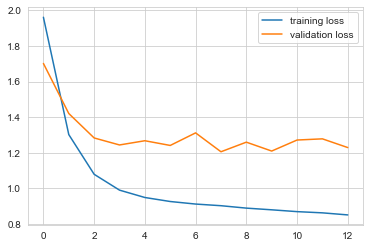

In [18]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

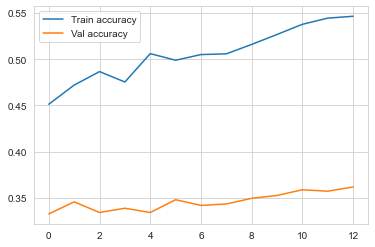

In [19]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [20]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,52,295,39
actual 1,41,342,60
actual 2,30,366,77


In [21]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.34097706879361916

In [22]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.4375

In [23]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.35538592027141647

In [24]:
rnn_proba = model.predict_proba(test_sequence)

Instructions for updating:
Please use `model.predict()` instead.


In [25]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.056174,0.555759,0.388068
1,0.075442,0.600084,0.324474
2,0.027258,0.419571,0.553171
3,0.025341,0.413144,0.561515
4,0.019339,0.398998,0.581663


In [26]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [27]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-21,2,2,1,0,0.056174,0.555759,0.388068
2015-10-22,3,2,1,0,0.075442,0.600084,0.324474
2015-10-23,4,0,2,0,0.027258,0.419571,0.553171
2015-10-25,6,2,2,1,0.025341,0.413144,0.561515
2015-10-26,0,2,2,1,0.019339,0.398998,0.581663


In [28]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-21,2,2,1,0,0.056174,0.555759,0.388068
2015-10-22,3,2,1,0,0.075442,0.600084,0.324474
2015-10-27,1,2,1,0,0.094488,0.456976,0.448536
2015-10-28,2,1,1,1,0.239943,0.433902,0.326154
2015-10-29,3,2,1,0,0.215854,0.444867,0.339279


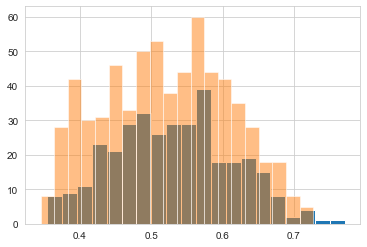

In [29]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [30]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-23,4,0,2,0,0.027258,0.419571,0.553171
2015-10-25,6,2,2,1,0.025341,0.413144,0.561515
2015-10-26,0,2,2,1,0.019339,0.398998,0.581663
2015-11-01,6,2,2,1,0.092793,0.416930,0.490277
2015-11-02,0,2,2,1,0.100019,0.395746,0.504235


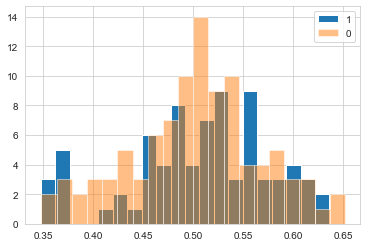

In [31]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [32]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 2

In [33]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [34]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [35]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [36]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [37]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
123/123 [==============================] - 2s 16ms/step - loss: 2.1019 - categorical_accuracy: 0.4396 - val_loss: 1.9164 - val_categorical_accuracy: 0.3497
Epoch 2/50
123/123 [==============================] - 1s 11ms/step - loss: 1.4721 - categorical_accuracy: 0.4834 - val_loss: 1.5462 - val_categorical_accuracy: 0.3528
Epoch 3/50
123/123 [==============================] - 1s 11ms/step - loss: 1.1891 - categorical_accuracy: 0.5036 - val_loss: 1.4294 - val_categorical_accuracy: 0.3467
Epoch 4/50
123/123 [==============================] - 1s 11ms/step - loss: 1.0656 - categorical_accuracy: 0.5046 - val_loss: 1.3061 - val_categorical_accuracy: 0.3444
Epoch 5/50
123/123 [==============================] - 1s 11ms/step - loss: 0.9948 - categorical_accuracy: 0.5141 - val_loss: 1.2932 - val_categorical_accuracy: 0.3513
Epoch 6/50
123/123 [==============================] - 1s 11ms/step - loss: 0.9559 - categorical_accuracy: 0.5159 - val_loss: 1.2738 - val_categorical_accuracy: 0.337

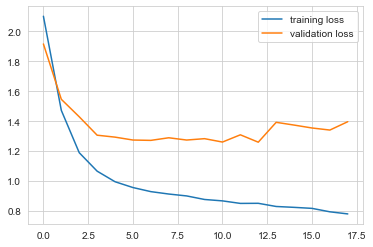

In [38]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

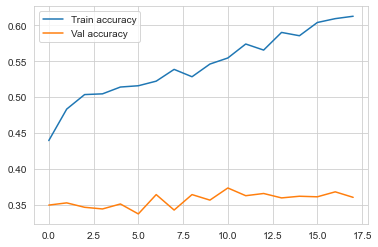

In [39]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [40]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,37,310,39
actual 1,32,349,62
actual 2,31,358,83


In [41]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.34316617502458213

In [42]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.45108695652173914

In [43]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.3597002497918401

In [44]:
rnn_proba = model.predict_proba(test_sequence)

In [45]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.029392,0.681406,0.289203
1,0.017488,0.662677,0.319835
2,0.050670,0.547328,0.402002
3,0.081498,0.462540,0.455962
4,0.041686,0.413499,0.544815


In [46]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [47]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-22,3,2,1,0,0.029392,0.681406,0.289203
2015-10-23,4,0,1,0,0.017488,0.662677,0.319835
2015-10-25,6,2,1,0,0.050670,0.547328,0.402002
2015-10-26,0,2,1,0,0.081498,0.462540,0.455962
2015-10-27,1,2,2,1,0.041686,0.413499,0.544815


In [48]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-22,3,2,1,0,0.029392,0.681406,0.289203
2015-10-23,4,0,1,0,0.017488,0.662677,0.319835
2015-10-25,6,2,1,0,0.050670,0.547328,0.402002
2015-10-26,0,2,1,0,0.081498,0.462540,0.455962
2015-10-28,2,1,1,1,0.177909,0.598959,0.223132


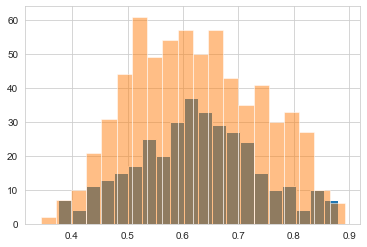

In [49]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [50]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-27,1,2,2,1,0.041686,0.413499,0.544815
2015-11-01,6,2,2,1,0.020315,0.464184,0.515500
2015-11-11,2,2,2,1,0.086378,0.425484,0.488138
2015-11-12,3,2,2,1,0.065378,0.366010,0.568612
2015-11-13,4,2,2,1,0.053735,0.279655,0.666611


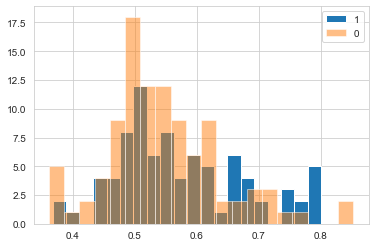

In [51]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [52]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 3

In [53]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [54]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [55]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [56]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [57]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
123/123 [==============================] - 3s 23ms/step - loss: 2.1195 - categorical_accuracy: 0.4428 - val_loss: 2.0032 - val_categorical_accuracy: 0.3415
Epoch 2/50
123/123 [==============================] - 2s 16ms/step - loss: 1.5192 - categorical_accuracy: 0.4832 - val_loss: 1.6128 - val_categorical_accuracy: 0.3438
Epoch 3/50
123/123 [==============================] - 2s 16ms/step - loss: 1.2368 - categorical_accuracy: 0.4860 - val_loss: 1.5208 - val_categorical_accuracy: 0.3369
Epoch 4/50
123/123 [==============================] - 2s 16ms/step - loss: 1.0941 - categorical_accuracy: 0.5147 - val_loss: 1.3834 - val_categorical_accuracy: 0.3392
Epoch 5/50
123/123 [==============================] - 2s 16ms/step - loss: 1.0130 - categorical_accuracy: 0.5063 - val_loss: 1.3733 - val_categorical_accuracy: 0.3546
Epoch 6/50
123/123 [==============================] - 2s 18ms/step - loss: 0.9710 - categorical_accuracy: 0.5088 - val_loss: 1.2713 - val_categorical_accuracy: 0.353

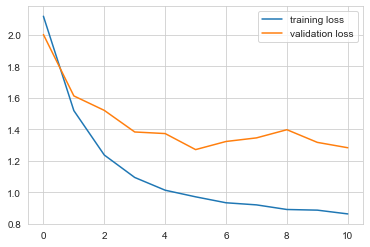

In [58]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

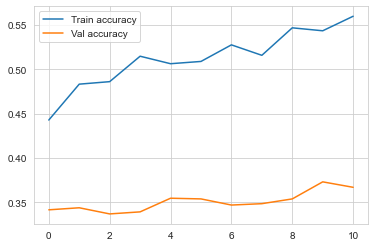

In [59]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [60]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,58,262,66
actual 1,43,310,90
actual 2,34,328,109


In [61]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.34444444444444444

In [62]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.41132075471698115

In [63]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.35965665236051503

In [64]:
rnn_proba = model.predict_proba(test_sequence)

In [65]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.061217,0.549526,0.389256
1,0.057143,0.479200,0.463657
2,0.049781,0.464863,0.485356
3,0.059719,0.482862,0.457419
4,0.074212,0.510600,0.415188


In [66]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [67]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-23,4,0,1,0,0.061217,0.549526,0.389256
2015-10-25,6,2,1,0,0.057143,0.479200,0.463657
2015-10-26,0,2,2,1,0.049781,0.464863,0.485356
2015-10-27,1,2,1,0,0.059719,0.482862,0.457419
2015-10-28,2,1,1,1,0.074212,0.510600,0.415188


In [68]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-23,4,0,1,0,0.061217,0.549526,0.389256
2015-10-25,6,2,1,0,0.057143,0.479200,0.463657
2015-10-27,1,2,1,0,0.059719,0.482862,0.457419
2015-10-28,2,1,1,1,0.074212,0.510600,0.415188
2015-10-29,3,2,1,0,0.075374,0.571237,0.353389


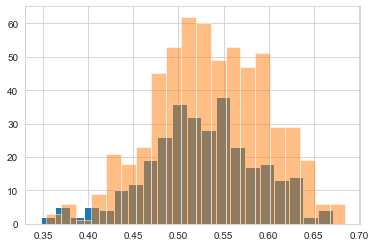

In [69]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [70]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-26,0,2,2,1,0.049781,0.464863,0.485356
2015-11-11,2,2,2,1,0.050752,0.435686,0.513563
2015-11-12,3,2,2,1,0.059661,0.365873,0.574466
2015-11-13,4,2,2,1,0.057505,0.339774,0.602721
2015-11-15,6,2,2,1,0.041577,0.378914,0.579510


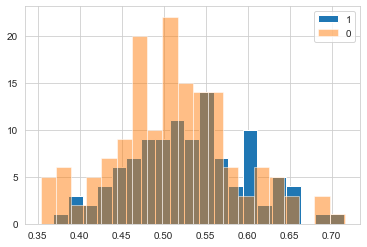

In [71]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [72]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 4

In [73]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [74]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [75]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [76]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [77]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
122/122 [==============================] - 3s 27ms/step - loss: 2.1764 - categorical_accuracy: 0.4639 - val_loss: 2.0583 - val_categorical_accuracy: 0.3395
Epoch 2/50
122/122 [==============================] - 2s 19ms/step - loss: 1.6136 - categorical_accuracy: 0.4882 - val_loss: 1.7261 - val_categorical_accuracy: 0.3349
Epoch 3/50
122/122 [==============================] - 3s 21ms/step - loss: 1.3174 - categorical_accuracy: 0.4951 - val_loss: 1.5629 - val_categorical_accuracy: 0.3380
Epoch 4/50
122/122 [==============================] - 3s 22ms/step - loss: 1.1587 - categorical_accuracy: 0.4918 - val_loss: 1.4365 - val_categorical_accuracy: 0.3503
Epoch 5/50
122/122 [==============================] - 3s 22ms/step - loss: 1.0607 - categorical_accuracy: 0.5023 - val_loss: 1.4840 - val_categorical_accuracy: 0.3510
Epoch 6/50
122/122 [==============================] - 3s 21ms/step - loss: 0.9977 - categorical_accuracy: 0.5174 - val_loss: 1.3508 - val_categorical_accuracy: 0.344

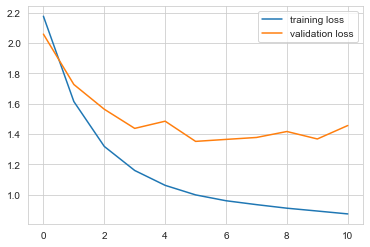

In [78]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

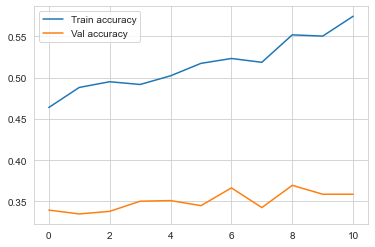

In [79]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [80]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,6,365,14
actual 1,2,417,24
actual 2,6,422,43


In [81]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.34634551495016613

In [82]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.5308641975308642

In [83]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.35797665369649806

In [84]:
rnn_proba = model.predict_proba(test_sequence)

In [85]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.029673,0.599356,0.370970
1,0.023669,0.500674,0.475657
2,0.030238,0.476218,0.493544
3,0.037276,0.522769,0.439955
4,0.024470,0.560769,0.414761


In [86]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [87]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-25,6,2,1,0,0.029673,0.599356,0.370970
2015-10-26,0,2,1,0,0.023669,0.500674,0.475657
2015-10-27,1,2,2,1,0.030238,0.476218,0.493544
2015-10-28,2,1,1,1,0.037276,0.522769,0.439955
2015-10-29,3,2,1,0,0.024470,0.560769,0.414761


In [88]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-25,6,2,1,0,0.029673,0.599356,0.370970
2015-10-26,0,2,1,0,0.023669,0.500674,0.475657
2015-10-28,2,1,1,1,0.037276,0.522769,0.439955
2015-10-29,3,2,1,0,0.024470,0.560769,0.414761
2015-10-30,4,2,1,0,0.017156,0.553989,0.428855


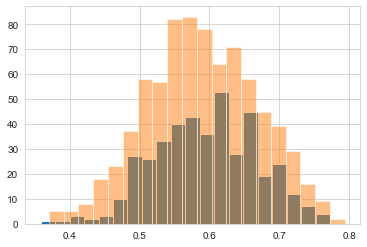

In [89]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [90]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-27,1,2,2,1,0.030238,0.476218,0.493544
2015-12-04,4,1,2,0,0.029459,0.432427,0.538114
2015-12-06,6,1,2,0,0.027912,0.460681,0.511407
2016-03-06,6,1,2,0,0.139806,0.424917,0.435277
2016-03-17,3,2,2,1,0.077936,0.444254,0.477811


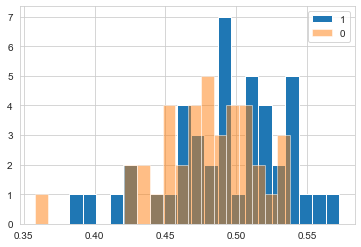

In [91]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [92]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 5

In [93]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [94]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [95]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [96]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [97]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
122/122 [==============================] - 4s 30ms/step - loss: 2.1739 - categorical_accuracy: 0.4445 - val_loss: 2.1192 - val_categorical_accuracy: 0.3413
Epoch 2/50
122/122 [==============================] - 3s 22ms/step - loss: 1.6139 - categorical_accuracy: 0.4830 - val_loss: 1.7354 - val_categorical_accuracy: 0.3428
Epoch 3/50
122/122 [==============================] - 3s 21ms/step - loss: 1.3302 - categorical_accuracy: 0.4965 - val_loss: 1.5663 - val_categorical_accuracy: 0.3513
Epoch 4/50
122/122 [==============================] - 3s 21ms/step - loss: 1.1576 - categorical_accuracy: 0.5186 - val_loss: 1.4338 - val_categorical_accuracy: 0.3336
Epoch 5/50
122/122 [==============================] - 3s 22ms/step - loss: 1.0579 - categorical_accuracy: 0.5132 - val_loss: 1.4276 - val_categorical_accuracy: 0.3582
Epoch 6/50
122/122 [==============================] - 3s 22ms/step - loss: 1.0011 - categorical_accuracy: 0.5260 - val_loss: 1.4172 - val_categorical_accuracy: 0.335

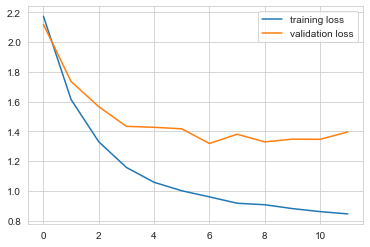

In [98]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

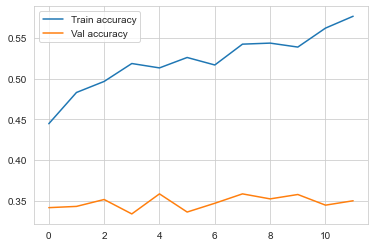

In [99]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [100]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,19,336,30
actual 1,17,375,51
actual 2,22,388,60


In [101]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.34121929026387626

In [102]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.425531914893617

In [103]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.35080645161290325

In [104]:
rnn_proba = model.predict_proba(test_sequence)

In [105]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.043919,0.480963,0.475118
1,0.066305,0.426087,0.507608
2,0.144202,0.440016,0.415782
3,0.098640,0.519396,0.381963
4,0.027435,0.536468,0.436098


In [106]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [107]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-26,0,2,1,0,0.043919,0.480963,0.475118
2015-10-27,1,2,2,1,0.066305,0.426087,0.507608
2015-10-28,2,1,1,1,0.144202,0.440016,0.415782
2015-10-29,3,2,1,0,0.098640,0.519396,0.381963
2015-10-30,4,2,1,0,0.027435,0.536468,0.436098


In [108]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-26,0,2,1,0,0.043919,0.480963,0.475118
2015-10-28,2,1,1,1,0.144202,0.440016,0.415782
2015-10-29,3,2,1,0,0.098640,0.519396,0.381963
2015-10-30,4,2,1,0,0.027435,0.536468,0.436098
2015-11-01,6,2,1,0,0.020950,0.533593,0.445457


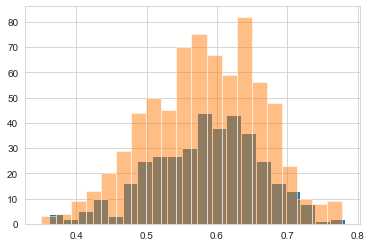

In [109]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [110]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-27,1,2,2,1,0.066305,0.426087,0.507608
2015-11-12,3,2,2,1,0.042990,0.465057,0.491953
2015-11-13,4,2,2,1,0.042716,0.429797,0.527487
2015-11-15,6,2,2,1,0.030824,0.484134,0.485043
2015-12-03,3,2,2,1,0.013662,0.459238,0.527101


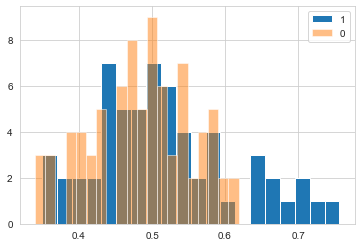

In [111]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [112]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 6

In [113]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [114]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [115]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [116]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [117]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
122/122 [==============================] - 3s 28ms/step - loss: 2.1775 - categorical_accuracy: 0.4598 - val_loss: 2.1233 - val_categorical_accuracy: 0.3462
Epoch 2/50
122/122 [==============================] - 3s 25ms/step - loss: 1.6171 - categorical_accuracy: 0.4805 - val_loss: 1.7494 - val_categorical_accuracy: 0.3500
Epoch 3/50
122/122 [==============================] - 3s 24ms/step - loss: 1.3210 - categorical_accuracy: 0.5000 - val_loss: 1.5774 - val_categorical_accuracy: 0.3400
Epoch 4/50
122/122 [==============================] - 3s 25ms/step - loss: 1.1622 - categorical_accuracy: 0.5051 - val_loss: 1.4337 - val_categorical_accuracy: 0.3254
Epoch 5/50
122/122 [==============================] - 3s 26ms/step - loss: 1.0664 - categorical_accuracy: 0.5092 - val_loss: 1.3664 - val_categorical_accuracy: 0.3524
Epoch 6/50
122/122 [==============================] - 3s 25ms/step - loss: 1.0022 - categorical_accuracy: 0.5269 - val_loss: 1.4439 - val_categorical_accuracy: 0.351

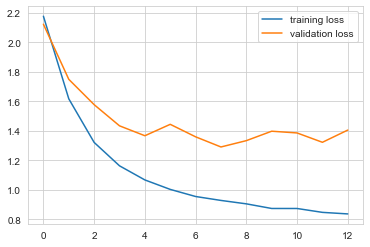

In [118]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

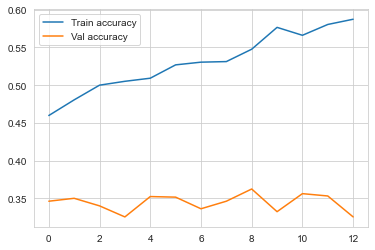

In [119]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [120]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,18,314,53
actual 1,18,320,105
actual 2,18,367,84


In [121]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.3196803196803197

In [122]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.34710743801652894

In [123]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.3250201126307321

In [124]:
rnn_proba = model.predict_proba(test_sequence)

In [125]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.040506,0.475191,0.484302
1,0.057260,0.483859,0.458881
2,0.071969,0.549296,0.378735
3,0.059414,0.537910,0.402676
4,0.050546,0.489900,0.459554


In [126]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [127]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-27,1,2,2,1,0.040506,0.475191,0.484302
2015-10-28,2,1,1,1,0.057260,0.483859,0.458881
2015-10-29,3,2,1,0,0.071969,0.549296,0.378735
2015-10-30,4,2,1,0,0.059414,0.537910,0.402676
2015-11-01,6,2,1,0,0.050546,0.489900,0.459554


In [128]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-28,2,1,1,1,0.057260,0.483859,0.458881
2015-10-29,3,2,1,0,0.071969,0.549296,0.378735
2015-10-30,4,2,1,0,0.059414,0.537910,0.402676
2015-11-01,6,2,1,0,0.050546,0.489900,0.459554
2015-11-02,0,2,1,0,0.042295,0.505896,0.451809


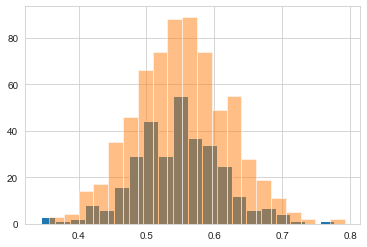

In [129]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [130]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-27,1,2,2,1,0.040506,0.475191,0.484302
2015-11-13,4,2,2,1,0.017979,0.472804,0.509218
2015-11-15,6,2,2,1,0.015015,0.478121,0.506864
2015-11-20,4,0,2,0,0.009578,0.465598,0.524824
2015-11-22,6,0,2,0,0.009396,0.492246,0.498358


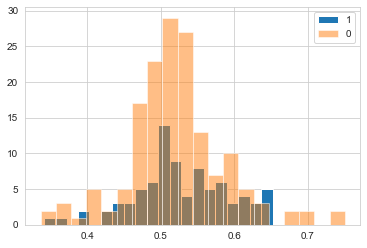

In [131]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [132]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 7

In [133]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [134]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [135]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [136]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [137]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
122/122 [==============================] - 4s 33ms/step - loss: 2.1988 - categorical_accuracy: 0.4560 - val_loss: 2.0828 - val_categorical_accuracy: 0.3441
Epoch 2/50
122/122 [==============================] - 3s 22ms/step - loss: 1.6520 - categorical_accuracy: 0.4748 - val_loss: 1.7412 - val_categorical_accuracy: 0.3387
Epoch 3/50
122/122 [==============================] - 3s 22ms/step - loss: 1.3501 - categorical_accuracy: 0.5006 - val_loss: 1.5946 - val_categorical_accuracy: 0.3364
Epoch 4/50
122/122 [==============================] - 3s 22ms/step - loss: 1.1804 - categorical_accuracy: 0.4983 - val_loss: 1.4726 - val_categorical_accuracy: 0.3341
Epoch 5/50
122/122 [==============================] - 3s 22ms/step - loss: 1.0775 - categorical_accuracy: 0.5196 - val_loss: 1.4361 - val_categorical_accuracy: 0.3395
Epoch 6/50
122/122 [==============================] - 3s 23ms/step - loss: 1.0118 - categorical_accuracy: 0.5094 - val_loss: 1.3675 - val_categorical_accuracy: 0.339

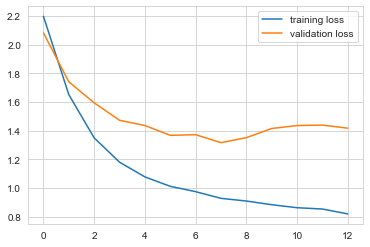

In [138]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

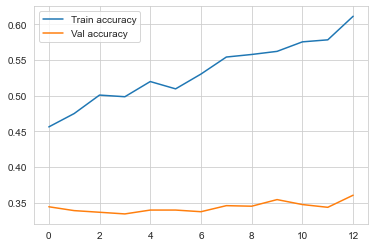

In [139]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [140]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,36,269,80
actual 1,23,330,90
actual 2,24,343,101


In [141]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.3503184713375796

In [142]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.3726937269372694

In [143]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.3553173948887057

In [144]:
rnn_proba = model.predict_proba(test_sequence)

In [145]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.071007,0.456914,0.472079
1,0.068802,0.469419,0.461779
2,0.060908,0.456543,0.482550
3,0.049466,0.385486,0.565048
4,0.041044,0.439815,0.519141


In [146]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [147]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-28,2,1,2,0,0.071007,0.456914,0.472079
2015-10-29,3,2,1,0,0.068802,0.469419,0.461779
2015-10-30,4,2,2,1,0.060908,0.456543,0.482550
2015-11-01,6,2,2,1,0.049466,0.385486,0.565048
2015-11-02,0,2,2,1,0.041044,0.439815,0.519141


In [148]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-29,3,2,1,0,0.068802,0.469419,0.461779
2015-11-03,1,2,1,0,0.029639,0.593247,0.377114
2015-11-04,2,2,1,0,0.019319,0.622037,0.358643
2015-11-05,3,2,1,0,0.013955,0.623049,0.362996
2015-11-06,4,0,1,0,0.011171,0.646499,0.342330


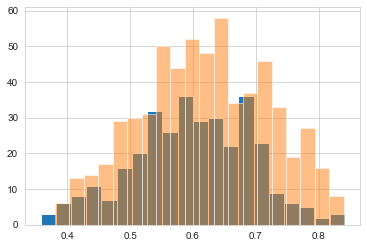

In [149]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [150]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-10-28,2,1,2,0,0.071007,0.456914,0.472079
2015-10-30,4,2,2,1,0.060908,0.456543,0.482550
2015-11-01,6,2,2,1,0.049466,0.385486,0.565048
2015-11-02,0,2,2,1,0.041044,0.439815,0.519141
2015-11-11,2,2,2,1,0.040385,0.448807,0.510808


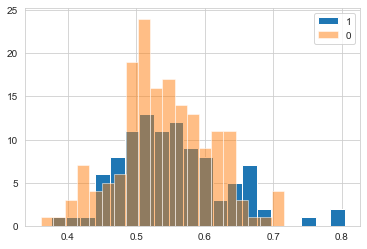

In [151]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()